# Map visualizations (Matt)

In [1]:
# imports and setup
from   ast import literal_eval
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   cartopy.io.img_tiles import MapboxTiles
from   collections import Counter, defaultdict
from   itertools import pairwise
import matplotlib.pyplot as plt
import os
import pandas as pd
import string
from   unidecode import unidecode

data_dir = os.path.join('..', 'data')
derived_dir = os.path.join(data_dir, 'derived')
fig_dir = os.path.join('..', 'figures')

conlit_input_file = 'CONLIT_CharData_AP_MW_11.csv.gz'
early_input_file = 'EARLY_CharData_AP_MW_11.csv.gz'

home_dir = os.path.expanduser('~')
mapbox_key_file = f'{home_dir}/Library/CloudStorage/GoogleDrive-mw966@cornell.edu/My Drive/Private/mapbox-api-key.txt'

## CONLIT

In [2]:
def string_to_list(x):
    lst = literal_eval(x.replace(', nan', "', ZZZZ'").replace('[nan, ', "'['").replace(', nan]', "']'"))
    return [i for i in lst if i != 'ZZZZ']

conlit = pd.read_csv(
    os.path.join(derived_dir, conlit_input_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
conlit = conlit.fillna('')

### Geo data for CONLIT

In [3]:
# regularize data to wilkens geo format
punctuation_to_space = str.maketrans({key:' ' for key in string.punctuation})

def regularize_string(place_string):
    return(unidecode(' '.join(place_string.translate(punctuation_to_space).lower().split())))

wi = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'geo.tsv.gz'),
    sep='\t',
    low_memory=False,
)
wi = wi.loc[wi.lang=='en']
wi.set_index('text_string', inplace=True)

# hand review data
hand = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'us_handreview.tsv'),
    sep='\t',
    index_col='text_string'
)

# restore some items from C19 hand review
hand.loc[
    [
        'hollywood', 
        'dallas', 
        'florence', 
        'kingston',
        'berkeley', 
        'queens', 
        'phoenix', 
        'woodstock', 
        'surrey',
        'orlando'
    ], 
    'ignore'
] = 0

# improve alises
hand.loc['kingston', 'alias_to'] = 'kingston jamaica'
hand.loc['baltic', ['ignore', 'alias_to']] = [0, 'baltic sea']

# alias places
for original_place, alias_to in hand.loc[(~hand.alias_to.isna()) & (~hand.ignore.equals(1)) & (hand.alias_to.isin(wi.index)), 'alias_to'].items():
    wi.loc[original_place] = wi.loc[alias_to]
    
# drop ignored places
wi.drop(hand.loc[hand.ignore==1].index, inplace=True, errors='ignore')

In [4]:
# drop unused places
wi_gpes = Counter()
for sequence in conlit.gpe_sequences:
    wi_gpes.update([regularize_string(i) for i in sequence])
wi.drop(wi.loc[~wi.index.isin(wi_gpes)].index, inplace=True, errors='ignore')

### CONLIT mapping

In [5]:
def get_lat_lon(place_string, geo_data=wi, extended=False):
    '''Assumes lookup string has been regularized if necessary'''
    try:
        if extended:
            return(geo_data.loc[place_string, ['lat', 'lon', 'country_short', 'admin_1_std', 'location_type']])
        else:
            return(geo_data.loc[place_string, ['lat', 'lon']])
    except (ValueError, KeyError):
        return(None)

# def get_route(list_of_places, geo_data=wi):
#     '''Takes a list of locations, returns a list of lat-lon tuples'''
#     route = []
#     seq = [regularize_string(i) for i in list_of_places if regularize_string(i) in geo_data.index]
#     for place in list_of_places:
#         route.append(get_lat_lon(place, geo_data=geo_data))
#     return(pd.DataFrame(route))

def get_hops(list_of_places, geo_data=wi):
    '''Takes a list oflocations, returns a list of origin-destination lat/lon tuples'''
    hop_list = []
    seq = [regularize_string(i) for i in list_of_places if regularize_string(i) in geo_data.index]
    for location1, location2 in pairwise(seq):
        loc1 = get_lat_lon(location1, geo_data, extended=True)
        loc2 = get_lat_lon(location2, geo_data, extended=True)
        if loc1 is None or loc2 is None: pass # should never happen, but check
        elif loc1.equals(loc2): pass # ignore identical places, even if called different names
        # eliminate place -> higher-order place in same admin area
        elif (loc1.location_type=='country' or loc2.location_type=='country') and \
           (loc2.country_short==loc1.country_short): pass
        elif (loc1.location_type=='administrative_area_level_1' or \
              loc2.location_type=='administrative_area_level_1') and \
             (loc2.country_short==loc1.country_short and \
              loc2.admin_1_std==loc1.admin_1_std): pass
        else:
            loc1 = tuple(loc1[['lat', 'lon']])
            loc2 = tuple(loc2[['lat', 'lon']])   
            hop_list.append((loc1, loc2))
    return(hop_list)

In [6]:
# get lat/lon data for all hops in all books
conlit_hops = conlit.gpe_sequences.apply(get_hops)

conlit_hops_counter = Counter()
for book in conlit_hops:
    for pair in book:
        hop = sorted(pair)
        conlit_hops_counter[tuple(hop)] += 1

CPU times: user 1min 12s, sys: 179 ms, total: 1min 12s
Wall time: 1min 12s


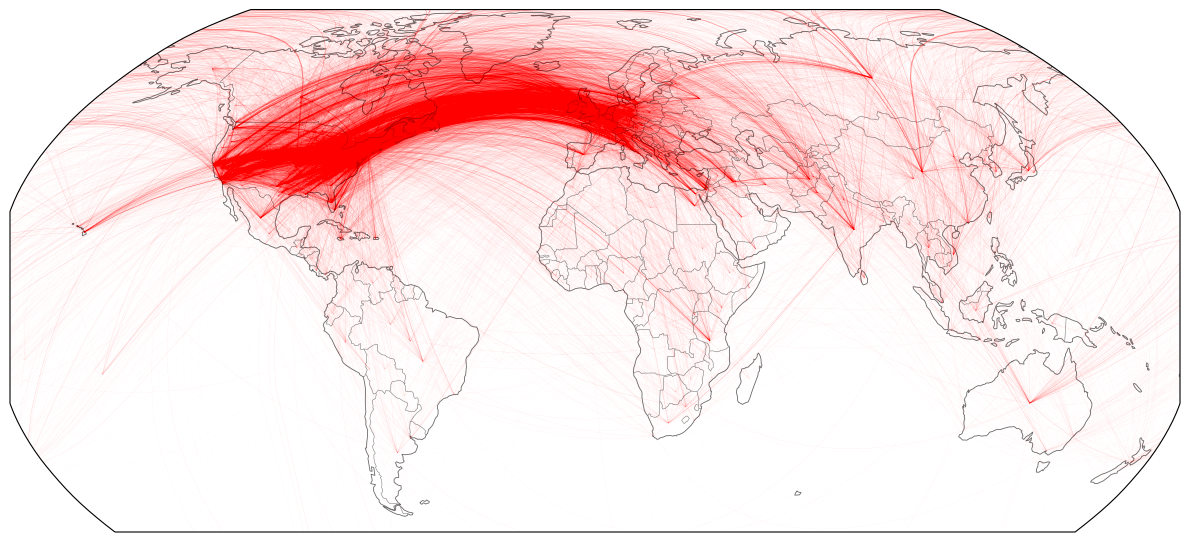

In [7]:
%%time
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-175, 175, -60, 85])
sizefactor = 1000/conlit_hops_counter.total()
for hop in conlit_hops_counter:
    plt.plot(
        [i[1] for i in hop],
        [i[0] for i in hop], 
        color='red', 
        marker=None, 
        alpha=0.4, 
        linewidth=conlit_hops_counter[hop]*sizefactor,
        transform=ccrs.Geodetic()
    )
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='dimgray', alpha=1.0)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray')
fig.canvas.draw()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'world_hop_map_CONLIT')+'.png', dpi=300)

In [15]:
print(f'Total CONLIT hops: {conlit_hops_counter.total()}')

Total CONLIT hops: 79899


## EARLY

In [8]:
early = pd.read_csv(
    os.path.join(derived_dir, early_input_file), 
    index_col='book_id',
    converters={
        'gpe_places': string_to_list,
        'nongpe_places': string_to_list,
        'all_places': string_to_list,
        'gpe_sequences': string_to_list
    },
)
early = early.fillna('')

### Geo data for EARLY

In [9]:
# reread geo data to retain relevant locations, etc.
wie = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'geo.tsv.gz'),
    sep='\t',
    low_memory=False,
)
wie = wie.loc[wie.lang=='en']
wie.set_index('text_string', inplace=True)

# hand review data
hand = pd.read_csv(
    os.path.join('..', '..', 'toponyms', 'us_handreview.tsv'),
    sep='\t',
    index_col='text_string'
)

# restore some items from C19 hand review
hand.loc[
    [
        'hollywood', 
        'dallas', 
        'florence', 
        'kingston',
        'berkeley', 
        'queens', 
        'phoenix', 
        'woodstock', 
        'surrey',
        'orlando'
    ], 
    'ignore'
] = 0

# improve alises
hand.loc['kingston', 'alias_to'] = 'kingston jamaica'
hand.loc['baltic', ['ignore', 'alias_to']] = [0, 'baltic sea']

# alias places
for original_place, alias_to in hand.loc[(~hand.alias_to.isna()) & (~hand.ignore.equals(1)) & (hand.alias_to.isin(wie.index)), 'alias_to'].items():
    wie.loc[original_place] = wie.loc[alias_to]

# drop ignored places
wie = wie.drop(hand.loc[hand.ignore==1].index, errors='ignore')

# drop unused places
wie_gpes = Counter()
for sequence in early.gpe_sequences:
    wie_gpes.update([regularize_string(i) for i in sequence])
wie.drop(wie.loc[~wie.index.isin(wie_gpes)].index, inplace=True, errors='ignore')

In [10]:
# drop unused places
wie_gpes = Counter()
for sequence in early.gpe_sequences:
    wie_gpes.update([regularize_string(i) for i in sequence])
wie.drop(wie.loc[~wie.index.isin(wie_gpes)].index, inplace=True, errors='ignore')

### EARLY mapping

In [11]:
# get lat/lon data for all hops in all books
early_hops = early.gpe_sequences.apply(get_hops, {'geo_data':wie})

early_hops_counter = Counter()
for book in early_hops:
    for pair in book:
        hop = sorted(pair)
        early_hops_counter[tuple(hop)] += 1

/var/folders/xd/m092nj891q71xlv9zcn1sd8r0000gn/T/ipykernel_86391/1350954246.py:2: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  early_hops = early.gpe_sequences.apply(get_hops, {'geo_data':wie})


CPU times: user 1min 23s, sys: 224 ms, total: 1min 24s
Wall time: 1min 24s


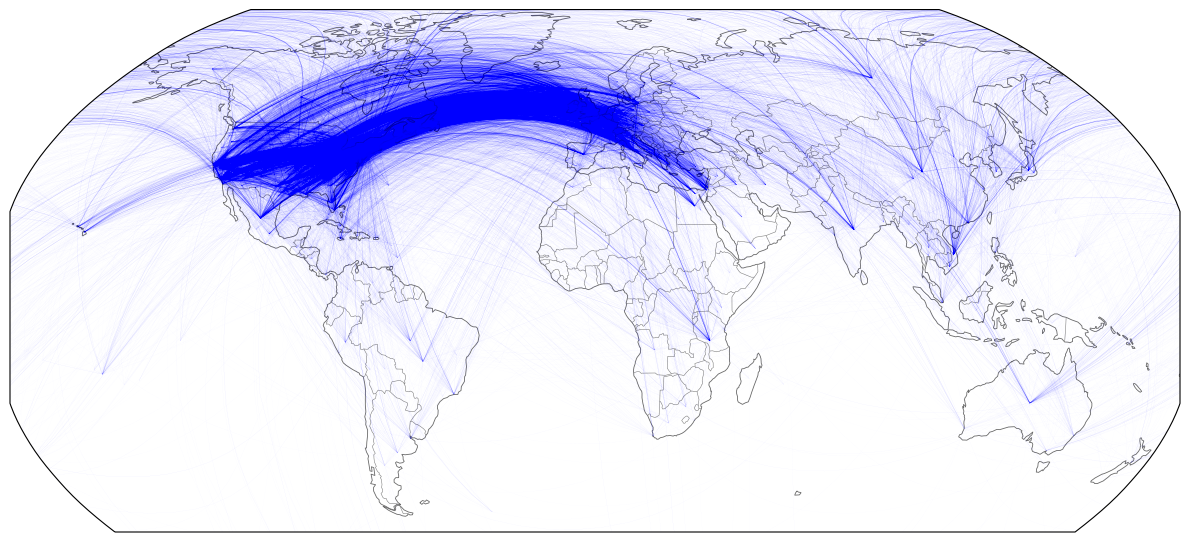

In [12]:
%%time
fig = plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-175, 175, -60, 85])
sizefactor = 1000/early_hops_counter.total()
for hop in early_hops_counter:
    plt.plot(
        [i[1] for i in hop],
        [i[0] for i in hop], 
        color='blue', 
        marker=None, 
        alpha=0.4, 
        linewidth=early_hops_counter[hop]*sizefactor,
        transform=ccrs.Geodetic()
    )
ax.add_feature(cfeature.COASTLINE, linewidth=0.6, edgecolor='dimgray', alpha=1.0)
ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray')
fig.canvas.draw()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'world_hop_map_EARLY')+'.png', dpi=300)

In [16]:
print(f'Total EARLY hops: {early_hops_counter.total()}')

Total EARLY hops: 113581
